Nombre de valeurs NaN dans le DataFrame: 0
Validation RMSE moyenne sur TimeSeriesSplit : 3515.96
RMSE sur données d'entraînement: 82.59168003356758
RMSE sur données de test: 3932.1379537210055
MAE sur données de test: 3007.8546779528956
MAPE sur données de test: 3.59%
R² sur données de test: 0.45108794746049763


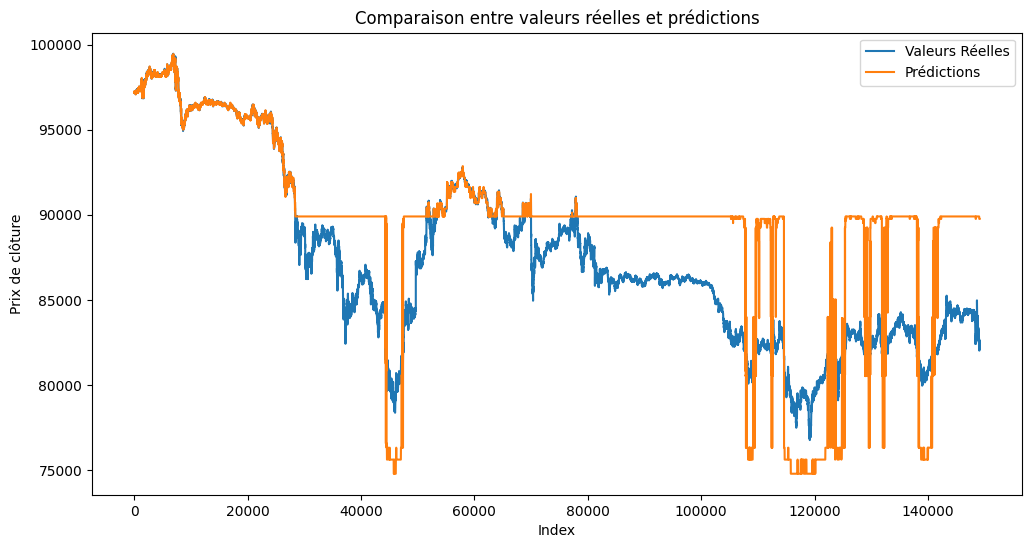

      feature  importance
1   min_price    0.404114
2   max_price    0.366492
4  open_price    0.163812
0    BB_upper    0.065556
3      EMA_50    0.000027


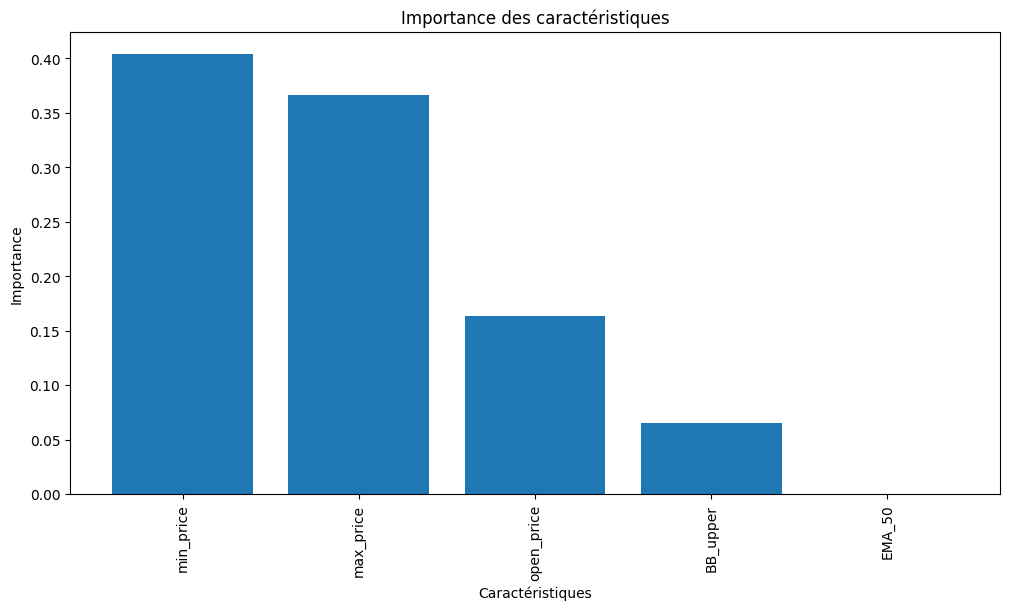

Modèle enregistré sous 'gradient_boosting_model.pkl'


In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# ----------------------------------------------------------------
# Étape 1 : Chargement des données et nettoyage
# ----------------------------------------------------------------
con = duckdb.connect("C:/Users/ouchaou/Desktop/Project_data_portfolio/data_pipeline_streaming_finnhub/src/duckdb/data/trades.duckdb")
query = "select BB_upper, min_price, max_price, EMA_50, open_price , close_price from trades_with_indicators_view where datetime > '2024-01-01 00:10:00';"
df = con.execute(query).fetchdf()
con.close()

# Suppression des lignes avec valeurs manquantes
df = df.dropna()
print(f"Nombre de valeurs NaN dans le DataFrame: {df.isna().sum().sum()}")

# ----------------------------------------------------------------
# Étape 2 : Création de la cible et sélection des features
# ----------------------------------------------------------------
df['target'] = df['close_price'].shift(-1)
df = df.dropna()  # Supprimer les lignes NaN après le shift

features = [
    'BB_upper', 'min_price', 'max_price', 'EMA_50', 'open_price'
]



X = df[features]
y = df['target']

# ----------------------------------------------------------------
# Étape 3 : Division train/test et normalisation
# ----------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------------------
# Étape 4 : Validation avec TimeSeriesSplit
# ----------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=10)
cv_rmse = []  # Stocker les erreurs pour chaque split

for train_index, val_index in tscv.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    model = GradientBoostingRegressor(
        n_estimators=178,
        learning_rate=0.045,
        max_depth=3,
        subsample=0.85,
        random_state=42,
        n_iter_no_change=10,
        validation_fraction=0.1
    )

    model.fit(X_tr, y_tr)
    
    # Validation
    y_pred_val = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    cv_rmse.append(rmse_val)

# Afficher la moyenne des RMSE sur les folds
print(f"Validation RMSE moyenne sur TimeSeriesSplit : {np.mean(cv_rmse):.2f}")

# ----------------------------------------------------------------
# Étape 5 : Entraînement du modèle final avec toutes les données d'entraînement
# ----------------------------------------------------------------
best_model = GradientBoostingRegressor(
    n_estimators=178,
    learning_rate=0.045,
    max_depth=3,
    subsample=0.85,
    random_state=42,
    n_iter_no_change=10,
    validation_fraction=0.1
)

best_model.fit(X_train_scaled, y_train)

# ----------------------------------------------------------------
# Étape 6 : Évaluation finale sur test set
# ----------------------------------------------------------------
y_pred_train = best_model.predict(X_train_scaled)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"RMSE sur données d'entraînement: {rmse_train}")

y_pred_test = best_model.predict(X_test_scaled)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE sur données de test: {rmse_test}")

# 1) MAE, MAPE, R²
mae_test = mean_absolute_error(y_test, y_pred_test)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"MAE sur données de test: {mae_test}")
print(f"MAPE sur données de test: {mape_test:.2f}%")
print(f"R² sur données de test: {r2_test}")

# ----------------------------------------------------------------
# Étape 7 : Visualisation des erreurs et prédictions
# ----------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Valeurs Réelles')
plt.plot(y_pred_test, label='Prédictions')
plt.legend()
plt.title("Comparaison entre valeurs réelles et prédictions")
plt.xlabel("Index")
plt.ylabel("Prix de clôture")
plt.show()

# Importance des features
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.title("Importance des caractéristiques")
plt.xlabel("Caractéristiques")
plt.ylabel("Importance")
plt.show()

# ----------------------------------------------------------------
# Étape 8 : Enregistrement du modèle final
# ----------------------------------------------------------------
joblib.dump(best_model, 'gradient_boosting_model.pkl')
print("Modèle enregistré sous 'gradient_boosting_model.pkl'")


In [44]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [35]:
from fastapi import FastAPI, HTTPException
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import uvicorn

app = FastAPI()

# Chargement du modèle et du scaler sauvegardés
model = joblib.load("gradient_boosting_model.pkl")
scaler = joblib.load("scaler.pkl")  # Assure-toi de sauvegarder également le scaler

features = [
    'open_price', 'close_price', 'max_price', 'min_price', 'total_volume',
    'price_range', 'volatility_pct', 'SMA_50', 'EMA_50', 'BB_upper', 
    'BB_lower', 'RSI', 'MACD', 'MACD_signal', 'volatility_7h', 'volatility_30h',
    'hour', 'day_of_week', 'month',
    'close_price_lag_1', 'close_price_lag_2', 'close_price_lag_3'
]
features = [
    'bb_upper', 'min_price', 'max_price', 'ema_50','max_price','open_price']

@app.get("/predict")
def predict(
    open_price: float,
    close_price: float,
    max_price: float,
    min_price: float,
    EMA_50: float,
    BB_upper: float,t
):
    # Créer un DataFrame avec les features
    data = {
        'open_price': [open_price],
        'close_price': [close_price],
        'max_price': [max_price],
        'min_price': [min_price],
        'EMA_50': [EMA_50],
        'BB_upper': [BB_upper]
    }
    df_features = pd.DataFrame(data, columns=features)
    
    # Mise à l'échelle
    df_scaled = scaler.transform(df_features)
    
    # Prédiction
    prediction = model.predict(df_scaled)[0]
    return {"predicted_close": prediction}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)



RuntimeError: asyncio.run() cannot be called from a running event loop